In [1]:
from tensorflow.io import read_file
from tensorflow.image import decode_jpeg
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers, applications
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

2023-01-02 16:33:45.648580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### so far, these are the pastries we have 30 pictures of --- all stored in the raw_data folder ###

available_pastries = [subdir for subdir in os.listdir('raw_data') if not subdir.startswith('.')]
available_pastries.sort()
available_pastries

['bolo_arroz', 'brigadeiro', 'ovos_moles', 'pastel_nata', 'pastel_tentugal']

In [3]:
### gets the minimum dimension from all images --- that will be the target_size ###

imgs = []
y = []
width_list = []
height_list = []

for pastry_name in available_pastries:
    for filename in os.scandir('raw_data/' + pastry_name):
        file_name, file_extension = os.path.splitext(filename.path)
        if filename.is_file() and file_extension == '.jpeg':

            # get image dimensions
            height, width = decode_jpeg(read_file(filename.path), 3).shape[:2]
            width_list.append(width)
            height_list.append(height)

# find smallest dimension from all files 
min_dim = min(min(height_list), min(width_list))

# give feedback
print('Minimum image height: ' +  str(min(height_list)))
print('Minimum image width: ' + str(min(width_list))) 
print('--> Target size: ' + str(min_dim)) 

2023-01-02 16:33:48.828771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Minimum image height: 168
Minimum image width: 203
--> Target size: 168


In [4]:
# Preprocessing using Keras ImageDataGenerator
# Using all available images to train (for now, just to make the model function)

train_batches = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input) \
    .flow_from_directory(directory='raw_data', target_size=(min_dim, min_dim), classes=available_pastries, batch_size=10)

Found 150 images belonging to 5 classes.


In [5]:
imgs, labels = next(train_batches)

In [6]:
def plot_images(images_array):
    """
    Plots preprocessed images
    """
    
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_array, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

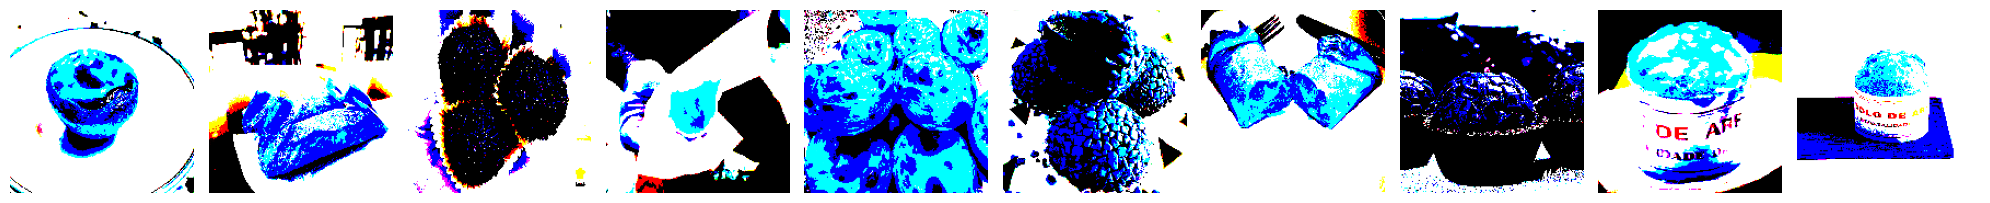

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [8]:
# Plot proprocessed images and corresponding labels

plot_images(imgs)
print(labels)

In [9]:
def initialize_model():
    
    model = Sequential()

    model.add(layers.Conv2D(16, kernel_size=(4, 4), activation='relu', padding='same', input_shape=(168, 168, 3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, kernel_size=(2, 2), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(len(available_pastries), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model  

In [12]:
X_train = imgs
y_train = labels

In [13]:
model = initialize_model()

es = EarlyStopping(patience=10)

history = model.fit(X_train, y_train,
                 epochs=100,
                 batch_size=32, 
                 verbose=1,
                 callbacks=[es],
                 validation_split=0.3)

Epoch 1/100
1/1 [==============================] - 1s 702ms/step - loss: 17.0794 - accuracy: 0.1429 - val_loss: 39.5548 - val_accuracy: 0.3333
Epoch 2/100
1/1 [==============================] - 0s 169ms/step - loss: 13.5015 - accuracy: 0.2857 - val_loss: 38.5311 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 122ms/step - loss: 5.9769 - accuracy: 0.5714 - val_loss: 41.0083 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 94ms/step - loss: 6.6683 - accuracy: 0.4286 - val_loss: 35.0618 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 90ms/step - loss: 5.1897 - accuracy: 0.5714 - val_loss: 26.6207 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 96ms/step - loss: 2.1201 - accuracy: 0.7143 - val_loss: 20.1334 - val_accuracy: 0.3333
Epoch 7/100
1/1 [==============================] - 0s 96ms/step - loss: 1.2650 - accuracy: 0.8571 - val_loss: 17.0726 - val_accuracy:

In [29]:
test_batches = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input) \
    .flow_from_directory(directory='test_data', target_size=(min_dim, min_dim), classes=available_pastries, batch_size=10, shuffle=False)

Found 3 images belonging to 5 classes.


In [30]:
predictions = model.predict(test_batches)
predictions

1/1 [==============================] - 0s 50ms/step


array([[1.2723462e-15, 1.9458524e-03, 1.0330855e-05, 9.9720275e-01,
        8.4103801e-04],
       [3.9598628e-23, 9.0209913e-01, 1.2932961e-09, 9.7900778e-02,
        5.9246947e-08],
       [8.5720376e-07, 4.1907084e-01, 6.8454244e-03, 5.6296259e-01,
        1.1120261e-02]], dtype=float32)

In [31]:
for prediction in predictions:
    print(available_pastries[np.argmax(prediction)])

pastel_nata
brigadeiro
pastel_nata


In [ ]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

In [ ]:
plot_loss_accuracy(history)